# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

print("Total words:", total_words)

Total words: 3375


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Calculate the total number of unique words in the corpus
total_words = len(tokenizer.word_index) + 1

print(f"Total Words (Vocabulary Size): {total_words}")


Total Words (Vocabulary Size): 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [8]:
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]

    #Generate n-gram sequences from the tokens
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(f"Total Sequences: {len(input_sequences)}")

Total Sequences: 15484


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [9]:


# Calculate the length of the longest sequence in input_sequences
max_sequence_len = max([len(seq) for seq in input_sequences])

# Pad the sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Convert to a numpy array
input_sequences = np.array(input_sequences)

print(f"Max Sequence Length: {max_sequence_len}")
print(f"Shape of Input Sequences: {input_sequences.shape}")


Max Sequence Length: 11
Shape of Input Sequences: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [10]:
# Split the sequences into predictors and labels
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

print(f"Shape of Predictors: {predictors.shape}")
print(f"Shape of Labels: {labels.shape}")


Shape of Predictors: (15484, 10)
Shape of Labels: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [11]:
from tensorflow.keras.utils import to_categorical

# One-Hot Encode the Labels
labels = to_categorical(labels, num_classes=total_words)

print(f"Shape of One-Hot Encoded Labels: {labels.shape}")


Shape of One-Hot Encoded Labels: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [13]:
model = Sequential([

    Embedding(total_words, 100, input_length=max_sequence_len-1),

    Bidirectional(LSTM(150, return_sequences=True)),

    Dropout(0.2),

    LSTM(100),

    Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    Dense(total_words, activation='softmax')
    
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [16]:
# Train the model
history = model.fit(
    predictors, 
    labels, 
    epochs=50, 
    verbose=1
)




Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0220 - loss: 7.3451
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.0221 - loss: 6.5070
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0241 - loss: 6.4142
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0301 - loss: 6.2921
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0334 - loss: 6.1948
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0385 - loss: 6.0953
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0397 - loss: 6.0264
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.0406 - loss: 5.9666
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0478 - loss: 5.8804
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0488 - loss: 5.8246
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.0512 - loss: 5.6547
Epoch 12/50
484/484 ━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

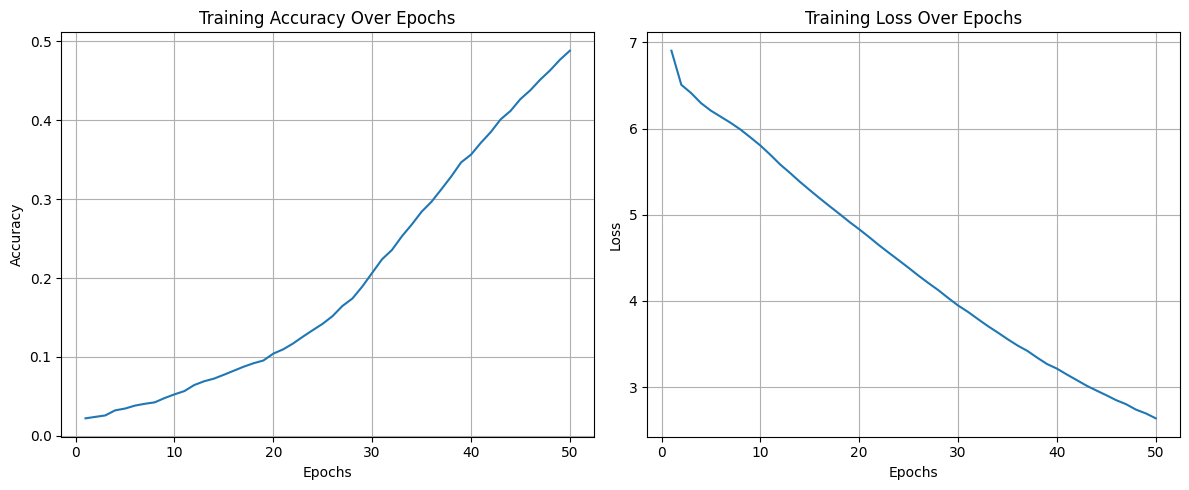

In [17]:
import matplotlib.pyplot as plt

# Get the accuracy and loss data from the training history
accuracy = history.history['accuracy']
loss = history.history['loss']

# Plot training accuracy over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy) + 1), accuracy)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot training loss over epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [18]:
# Define the seed text and the number of words to generate
seed_text = "To be, or not to be, that is the question"
next_words = 50




Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [ ]:
# Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad the tokenized sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Predict the next word
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=-1)[0]
        
        # Find the predicted word
        output_word = tokenizer.index_word[predicted_word_index]
        c
        # Append the predicted word to the seed text
        seed_text += " " + output_word
        
    return seed_text

# Generate the text
generated_text = generate_text(seed_text, next_words, model, max_sequence_len)
print(generated_text)

To be, or not to be, that is the question best of laws dead gone new seen hate remains none bright times new new pride we flatter'd be bevel rehearse are rare night of pleasure wrinkles memory near slain done foes race ' ' new ' live so kind still bright more spent ' still still seen room me are


Experiment with at least 3 different seed_text strings and see what happens!

In [21]:
seed_text1 = "Shall I compare thee to a summer's day"
generated_text1 = generate_text(seed_text1, 50, model, max_sequence_len)
print(generated_text1)

seed_text2 = "When in disgrace with fortune and men's eyes"
generated_text2 = generate_text(seed_text2, 50, model, max_sequence_len)
print(generated_text2)

seed_text3 = "O, she doth teach the torches to burn bright"
generated_text3 = generate_text(seed_text3, 50, model, max_sequence_len)
print(generated_text3)



Shall I compare thee to a summer's day still thought kind so kind still seen aside old rhyme play'st ' new rare light rare cross ' new rare light rare night of state strange kindness forth be great cross ' bright that word defaced bad old old where now his spring ' light ' still may say so
When in disgrace with fortune and men's eyes alone grows do willingly slow well and seen exceeds rare old rhyme play'st ' new ' live best will live foes kindness forth die so die so die so green thee light more cross ' ' so kind new rare ' level of thee dyed said live so dearer end
O, she doth teach the torches to burn bright days respect 'will ' are so kind of ill cheeks well or thee shall live great strife ' so kind new rare ' kind are that more more thought still still old rhyme sadly rare light cross dead rhyme cross rare rare ' so kind ' new and hide me
